In [11]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf

In [12]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')


In [13]:
# read data
train = pd.read_csv('./data/train.txt', delimiter=';', header=None, names=['data', 'label'])
test = pd.read_csv('./data/test.txt', delimiter=';', header=None, names=['data', 'label'])
val = pd.read_csv('./data/val.txt', delimiter=';', header=None, names=['data', 'label'])
comb_data = pd.concat([train, val, test])
comb_data.shape

(20000, 2)

In [14]:
le = LabelEncoder()
comb_data['label_enc'] = le.fit_transform(comb_data['label'])
comb_data.head()

,data,label,label_enc
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


In [15]:
def tokenize_data(df):
    sents = df['data']
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = []
    for i in sents:
        tokens.append(tokenizer.tokenize(i.lower()))
    return tokens
tokenized = tokenize_data(comb_data)

In [16]:
def remove_stopwords(tokenized):
    sw = set(stopwords.words('english'))
    sw_removed = []
    for sent in tokenized:
        filtered = []
        for word in sent:
            if word not in sw:
                filtered.append(word)
        sw_removed.append(filtered)
    return sw_removed
stopwords_removed = remove_stopwords(tokenized)

In [17]:
def lemmatize(processed):
    lemma = WordNetLemmatizer()
    lemmatized = []
    for sent in processed:
        filtered = []
        for word in sent:
            filtered.append(lemma.lemmatize(word, pos='v'))
        lemmatized.append(filtered)
    return lemmatized
lemmatized = lemmatize(stopwords_removed)

In [18]:
final_data = []
# each l is a list of processed words
for l in lemmatized:
    final_data.append(' '.join(l))
d = {'data': final_data, 'label': comb_data['label_enc'], 'label_raw': comb_data['label']}
final_df = pd.DataFrame(data=d)

In [19]:
final_df.head()

,data,label,label_raw
0,didnt feel humiliate,4,sadness
1,go feel hopeless damn hopeful around someone c...,4,sadness
2,im grab minute post feel greedy wrong,0,anger
3,ever feel nostalgic fireplace know still property,3,love
4,feel grouchy,0,anger


In [20]:
from sklearn.model_selection import train_test_split
def prepare_dataset(df, test_size=0.2, seq_len=30, embedding_dim=100):
    xtrain, xtest, ytrain, ytest = train_test_split(df['data'], df['label'], test_size=test_size, random_state=42)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['data'])
    word_inds = tokenizer.word_index
    vocab_size = len(word_inds) + 1

    ytrain = tf.keras.utils.to_categorical(ytrain, dtype='uint8')
    ytest = tf.keras.utils.to_categorical(ytest, dtype='uint8')

    xtrain = pad_sequences(tokenizer.texts_to_sequences(xtrain), maxlen=seq_len)
    xtest = pad_sequences(tokenizer.texts_to_sequences(xtest), maxlen=seq_len)
    print('x: ', xtrain.shape)
    print(xtest.shape)
    print('y: ', ytrain.shape)
    print(ytest.shape)
    print(vocab_size)
    return xtrain, xtest, ytrain, ytest, vocab_size

xtrain, xtest, ytrain, ytest, vocab_size = prepare_dataset(final_df)

x:  (16000, 30)
(4000, 30)
y:  (16000, 6)
(4000, 6)
13660


## CNN classifier

In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, Dense, GlobalMaxPooling1D, MaxPooling1D, Dropout, Embedding, Input, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.python.ops.gen_batch_ops import batch

In [22]:
class CNN:
    def __init__(self, vocab_size, batch_size=256, epochs=20, embedding_dim=100, seq_len=30):
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.seq_len = seq_len
        self.early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000001, verbose=0)
        self.model = self.build_model(vocab_size)

    def build_model(self, vocab_size):
        inputs = Input(shape=(self.seq_len,), dtype=np.int32)
        embedding = Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=self.seq_len, trainable=True)
        model = embedding(inputs)
        model = Dropout(0.2)(model)

        # conv block 1
        model = Conv1D(128, 3, activation='relu')(model)
        model = Conv1D(128, 3, activation='relu')(model)
        model = MaxPooling1D()(model)

        # conv block 2
        model = Conv1D(64, 3, activation='relu')(model)
        model = Conv1D(64, 3, activation='relu')(model)
        model = Dropout(0.2)(model)

        # conv block 3
        model = Conv1D(64, 3, activation='relu')(model)
        model = Conv1D(32, 3, activation='relu')(model)
        model = GlobalMaxPooling1D()(model)

        # FC
        model = BatchNormalization()(model)
        model = Dense(512, activation='relu')(model)
        model = Dense(128, activation='relu')(model)
        model = Dropout(0.2)(model)

        # output
        outputs = Dense(6, activation='softmax')(model)
        return tf.keras.Model(inputs, outputs, name='cnn')

    def summary(self):
        return self.model.summary()

    def train(self, xtrain, xtest, ytrain, ytest):
        opt = Adam(learning_rate=0.01)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
        history = self.model.fit(xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs, validation_data=(xtest, ytest), callbacks=[self.reduce_lr], verbose=1)
        return history

    def predict(self, data):
        # assume data is already cleaned
        return self.model.predict(data)

In [23]:
cnn = CNN(vocab_size)
history = cnn.train(xtrain, xtest, ytrain, ytest)

Epoch 1/20
63/63 [==============================] - 20s 56ms/step - loss: 1.5607 - accuracy: 0.3586 - auc: 0.7264 - val_loss: 4.1716 - val_accuracy: 0.3450 - val_auc: 0.6796
Epoch 2/20
63/63 [==============================] - 2s 30ms/step - loss: 0.9163 - accuracy: 0.6554 - auc: 0.9157 - val_loss: 2.0137 - val_accuracy: 0.6445 - val_auc: 0.8640
Epoch 3/20
63/63 [==============================] - 2s 31ms/step - loss: 0.5929 - accuracy: 0.7889 - auc: 0.9643 - val_loss: 1.3378 - val_accuracy: 0.6578 - val_auc: 0.9104
Epoch 4/20
63/63 [==============================] - 2s 32ms/step - loss: 0.4592 - accuracy: 0.8443 - auc: 0.9775 - val_loss: 1.2110 - val_accuracy: 0.6952 - val_auc: 0.9127
Epoch 5/20
63/63 [==============================] - 2s 32ms/step - loss: 0.3823 - accuracy: 0.8712 - auc: 0.9835 - val_loss: 0.6931 - val_accuracy: 0.7738 - val_auc: 0.9583
Epoch 6/20
63/63 [==============================] - 2s 30ms/step - loss: 0.3287 - accuracy: 0.8902 - auc: 0.9871 - val_loss: 0.7845 - 

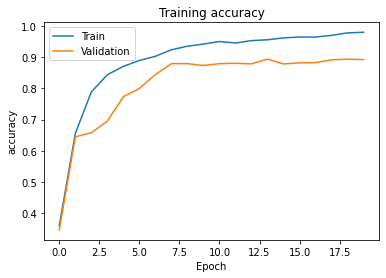

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
def plot_outs(history, name):
    plt.plot(history.history[name])
    plt.plot(history.history['val_'+name])
    plt.title('Training '+name)
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.clf()

plot_outs(history, 'accuracy')


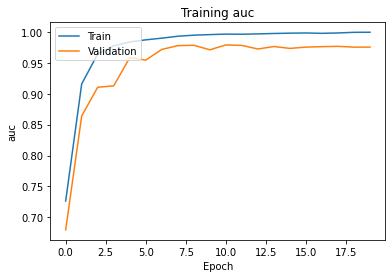

<Figure size 432x288 with 0 Axes>

In [25]:
plot_outs(history, 'auc')

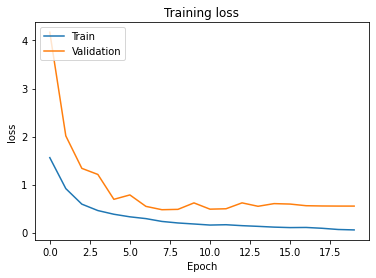

<Figure size 432x288 with 0 Axes>

In [26]:
plot_outs(history, 'loss')

In [27]:
from tensorflow.keras.layers import LSTM, Bidirectional
class RNN:
    def __init__(self, vocab_size, batch_size=256, epochs=20, embedding_dim=100, seq_len=30):
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.seq_len = seq_len
        self.early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000001, verbose=0)
        self.model = self.build_model(vocab_size)

    def build_model(self, vocab_size):
        inputs = Input(shape=(self.seq_len,), dtype=np.int32)
        embedding = Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=self.seq_len, trainable=True)
        model = embedding(inputs)
        model = Dropout(0.2)(model)

        model = Bidirectional(LSTM(4, input_shape=(self.seq_len, 1), return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4, return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4, return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4))(model)
        outputs = Dense(6, activation='softmax')(model)
        return tf.keras.Model(inputs, outputs)

    def summary(self):
        return self.model.summary()

    def train(self, xtrain, xtest, ytrain, ytest):
        opt = Adam(learning_rate=0.01)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
        history = self.model.fit(xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs, validation_data=(xtest, ytest), callbacks=[self.reduce_lr])
        return history

    def predict(self, data):
        return self.model.predict(data)


In [28]:
lstm = RNN(vocab_size)
history_lstm = lstm.train(xtrain, xtest, ytrain, ytest)

Epoch 1/20
63/63 [==============================] - 39s 197ms/step - loss: 1.4465 - accuracy: 0.4756 - auc: 0.7715 - val_loss: 1.2808 - val_accuracy: 0.5610 - val_auc: 0.82516
Epoch 2/20
63/63 [==============================] - 7s 108ms/step - loss: 1.1346 - accuracy: 0.5886 - auc: 0.8659 - val_loss: 1.0582 - val_accuracy: 0.6100 - val_auc: 0.8853
Epoch 3/20
63/63 [==============================] - 7s 107ms/step - loss: 0.8475 - accuracy: 0.7020 - auc: 0.9270 - val_loss: 0.7722 - val_accuracy: 0.7682 - val_auc: 0.9352
Epoch 4/20
63/63 [==============================] - 7s 107ms/step - loss: 0.6498 - accuracy: 0.7941 - auc: 0.9543 - val_loss: 0.7524 - val_accuracy: 0.7745 - val_auc: 0.9380
Epoch 5/20
63/63 [==============================] - 7s 107ms/step - loss: 0.5668 - accuracy: 0.8170 - auc: 0.9652 - val_loss: 0.6865 - val_accuracy: 0.7865 - val_auc: 0.9494
Epoch 6/20
63/63 [==============================] - 7s 109ms/step - loss: 0.4672 - accuracy: 0.8486 - auc: 0.9766 - val_loss: 0.

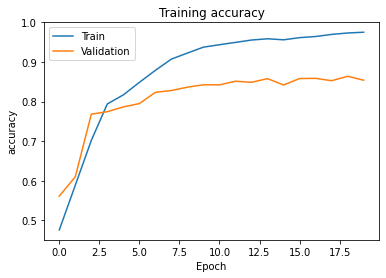

<Figure size 432x288 with 0 Axes>

In [29]:
plot_outs(history_lstm, 'accuracy')

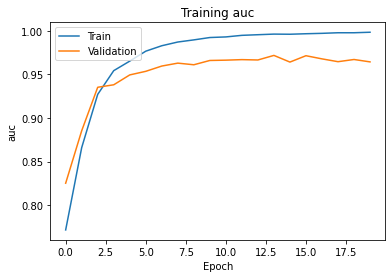

<Figure size 432x288 with 0 Axes>

In [30]:
plot_outs(history_lstm, 'auc')

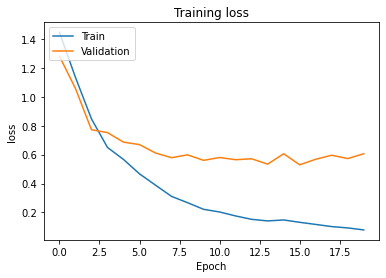

<Figure size 432x288 with 0 Axes>

In [31]:
plot_outs(history_lstm, 'loss')

# Transformer

In [32]:
from tensorflow.keras import layers
from tensorflow import keras

class Transformer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(Transformer, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=0.001)
        self.layernorm2 = layers.LayerNormalization(epsilon=0.001)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        x = self.attention(inputs, inputs)
        x = self.dropout1(x, training=training)
        out1 = self.layernorm1(inputs + x)
        y = self.ffn(x)
        y = self.dropout2(x, training=training)
        return self.layernorm2(out1 + y)

class Embed(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, glove_matrix=None):
        super(Embed, self).__init__()
        if glove_matrix is not None:
            self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[glove_matrix], trainable=False)
        else:
            self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [33]:
def build_transformer(maxlen=30, embed_dim=100, num_heads=4, ff_dim=128, vocab_size=vocab_size):
    trans = Transformer(embed_dim, num_heads, ff_dim, rate=0.3)
    embed = Embed(maxlen, vocab_size, embed_dim)
    input = Input(shape=(maxlen,))
    x = embed(input)
    x = trans(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)
    return keras.Model(input, output)

In [34]:
transformer = build_transformer()
opt = Adam(learning_rate=0.01)
transformer.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000001, verbose=0)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
history = transformer.fit(xtrain, ytrain, batch_size=256, epochs=20, validation_data=(xtest, ytest), callbacks=[early_stopping, reduce_lr])

Epoch 1/20
63/63 [==============================] - 6s 47ms/step - loss: 1.6113 - accuracy: 0.3223 - auc: 0.7029 - val_loss: 1.4878 - val_accuracy: 0.3458 - val_auc: 0.7674
Epoch 2/20
63/63 [==============================] - 2s 30ms/step - loss: 1.0698 - accuracy: 0.5901 - auc: 0.8838 - val_loss: 0.7918 - val_accuracy: 0.7130 - val_auc: 0.9377
Epoch 3/20
63/63 [==============================] - 2s 29ms/step - loss: 0.6624 - accuracy: 0.7791 - auc: 0.9549 - val_loss: 0.4982 - val_accuracy: 0.8435 - val_auc: 0.9724
Epoch 4/20
63/63 [==============================] - 2s 30ms/step - loss: 0.4202 - accuracy: 0.8699 - auc: 0.9794 - val_loss: 0.4607 - val_accuracy: 0.8655 - val_auc: 0.9759
Epoch 5/20
63/63 [==============================] - 2s 30ms/step - loss: 0.3140 - accuracy: 0.8989 - auc: 0.9878 - val_loss: 0.4010 - val_accuracy: 0.8800 - val_auc: 0.9806
Epoch 6/20
63/63 [==============================] - 2s 30ms/step - loss: 0.2428 - accuracy: 0.9195 - auc: 0.9921 - val_loss: 0.4074 - v

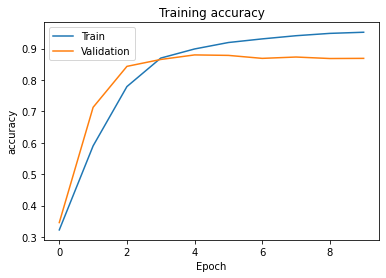

<Figure size 432x288 with 0 Axes>

In [35]:
plot_outs(history, 'accuracy')

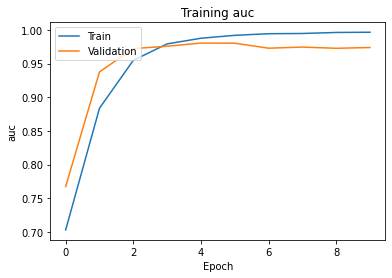

<Figure size 432x288 with 0 Axes>

In [36]:
plot_outs(history, 'auc')

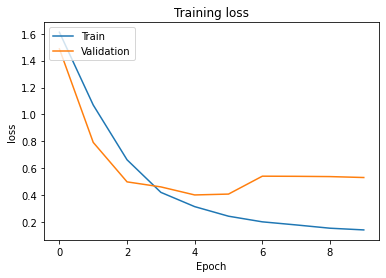

<Figure size 432x288 with 0 Axes>

In [37]:
plot_outs(history, 'loss')

# Results
CNN outperforms other two models. Transformer tends toward overfitting. Results might be different for others; I never seeded my runs.

In [38]:
from sklearn.metrics import classification_report
pred = cnn.predict(xtest)
pred.shape

(4000, 6)

In [39]:
final_df['label_raw'].value_counts().sort_index()

anger       2709
fear        2373
joy         6761
love        1641
sadness     5797
surprise     719
Name: label_raw, dtype: int64

In [40]:
cm = classification_report(np.argmax(ytest, axis=1), np.argmax(pred, axis=1), target_names=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

In [41]:
print(cm)

              precision    recall  f1-score   support

       anger       0.91      0.89      0.90       540
        fear       0.86      0.84      0.85       442
         joy       0.94      0.91      0.92      1335
        love       0.72      0.79      0.75       332
     sadness       0.94      0.95      0.95      1195
    surprise       0.63      0.72      0.67       156

    accuracy                           0.89      4000
   macro avg       0.83      0.85      0.84      4000
weighted avg       0.90      0.89      0.89      4000



## Song recommendation

In [42]:
comb_data.head()

,data,label,label_enc
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


In [43]:
def process_data(df):
    df_strat = df.groupby('label').apply(lambda x: x.sample(3)).droplevel(level=0)
    # print(df_strat)
    tokenized = tokenize_data(df_strat)
    sw_removed = remove_stopwords(tokenized)
    lemmatized = lemmatize(sw_removed)
    final_data = []
    # each l is a list of processed words
    for l in lemmatized:
        final_data.append(' '.join(l))
    d = {'data': final_data, 'data_raw': df_strat['data'], 'label': df_strat['label_enc'], 'label_raw': df_strat['label']}
    final_df = pd.DataFrame(data=d)
    return final_df
    

In [44]:
test_df = process_data(comb_data)
test_df

,data,data_raw,label,label_raw
214,id kick gear feel irritable motivation ever,id kick myself into gear but i just feel irrit...,0,anger
9204,forget take meds morning predictably feel irri...,i forgot to take my meds this morning and i am...,0,anger
4584,know still feel kind agitate also switch feel ...,i know that i still feel kind of agitated but ...,0,anger
664,bus stop hear squeak baachan trolley feel litt...,i am at the bus stop and i hear the squeak of ...,1,fear
14472,cant help feel little bite agitate,i cant help but feel a little bit agitated,1,fear
295,feel strange talk less serious things right li...,i feel strange talking about less serious thin...,1,fear
11745,feel gnaw hole throughout flawless soul,i feel them gnawing out holes all throughout m...,2,joy
10340,im feel lucky see jump google logo may take time,im feeling lucky see the jumping google logo i...,2,joy
8988,talk feel like lot get resolve,i talk to you i feel like a lot gets resolved,2,joy
88,still feel like im get away something naughty,i still feel like im getting away with somethi...,3,love


In [45]:
final_df.head()

,data,label,label_raw
0,didnt feel humiliate,4,sadness
1,go feel hopeless damn hopeful around someone c...,4,sadness
2,im grab minute post feel greedy wrong,0,anger
3,ever feel nostalgic fireplace know still property,3,love
4,feel grouchy,0,anger


In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_df['data'])
test_data = pad_sequences(tokenizer.texts_to_sequences(test_df['data']), maxlen=30)

In [47]:
probs = np.argmax(cnn.predict(test_data), axis=1)

In [48]:
probs_trans = np.argmax(transformer(test_data), axis=1)

In [49]:
from sklearn.metrics import accuracy_score
print(accuracy_score(list(test_df['label']), probs))
print(accuracy_score(list(test_df['label']), probs_trans))

1.0
0.8333333333333334


1.0 = perfect accuracy
## Song data

In [50]:
song_data = pd.read_csv('data/songs.csv', usecols=['song_name', 'genre', 'valence', 'energy', 'danceability', 'loudness'])

C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [69]:
print(song_data.shape)
song_data = song_data.drop_duplicates(subset='song_name')
print(song_data.shape)

(42305, 6)
(15440, 6)


In [70]:
print(song_data.shape)
song_data.head()

(15440, 6)


,danceability,energy,loudness,valence,genre,song_name
0,0.831,0.814,-7.364,0.3890,Dark Trap,Mercury: Retrograde
1,0.719,0.493,-7.230,0.1240,Dark Trap,Pathology
2,0.850,0.893,-4.783,0.0391,Dark Trap,Symbiote
3,0.476,0.781,-4.710,0.1750,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote)
4,0.798,0.624,-7.668,0.5910,Dark Trap,Venom


In [71]:
song_data_clean = song_data.dropna()

In [72]:
song_data_clean['genre'].value_counts()

Underground Rap    4410
Dark Trap          4221
Hiphop             1750
RnB                1435
Emo                1298
Rap                1030
Trap Metal         1001
Pop                 294
Name: genre, dtype: int64

In [73]:
song_data_clean['energy'].min(), song_data_clean['energy'].max()

(0.000243, 0.999)

In [74]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
le = LabelEncoder()
sc = MinMaxScaler()
cols = ['danceability', 'energy', 'loudness', 'valence']
song_data_clean['genre_enc'] = le.fit_transform(song_data_clean['genre'])
song_data_clean[cols] = sc.fit_transform(song_data_clean[cols])

C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [75]:
song_data_clean.head()

,danceability,energy,loudness,valence,genre,song_name,genre_enc
0,0.829884,0.814770,0.727688,0.383990,Dark Trap,Mercury: Retrograde,0
1,0.708527,0.493370,0.731439,0.107776,Dark Trap,Pathology,0
2,0.850471,0.893868,0.799944,0.019283,Dark Trap,Symbiote,0
3,0.445227,0.781729,0.801988,0.160934,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),0
4,0.794127,0.624533,0.719177,0.594538,Dark Trap,Venom,0


For n_clusters=2, SSE is 1265.4361054439241
For n_clusters=3, SSE is 978.7362630626286
For n_clusters=4, SSE is 830.8088403336114
For n_clusters=5, SSE is 726.8467295229395
For n_clusters=6, SSE is 648.9788530662937
For n_clusters=7, SSE is 591.00627114746
For n_clusters=8, SSE is 551.480433095463
For n_clusters=9, SSE is 514.6493429582085


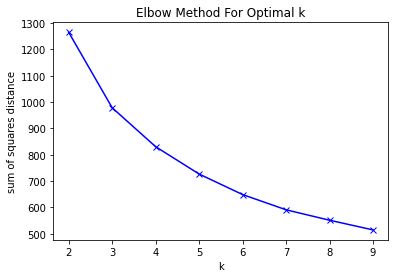

In [76]:
sse = []
for i in range(2, 10):
    kc = KMeans(n_clusters=i, n_init=20)
    kc = kc.fit(song_data_clean.drop(['song_name', 'genre', 'genre_enc'], axis=1))
    sse.append(kc.inertia_)
    print(f'For n_clusters={i}, SSE is {kc.inertia_}')
plt.plot(range(2,10), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squares distance')
plt.title('Elbow Method For Optimal k')
plt.show()

In [77]:
kc = KMeans(n_clusters=6, n_init=20)
song_data_clean['clusters'] = kc.fit_predict(song_data_clean.drop(['song_name', 'genre', 'genre_enc'], axis=1))

C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
song_data_clean.head()

,danceability,energy,loudness,valence,genre,song_name,genre_enc,clusters
0,0.829884,0.814770,0.727688,0.383990,Dark Trap,Mercury: Retrograde,0,1
1,0.708527,0.493370,0.731439,0.107776,Dark Trap,Pathology,0,1
2,0.850471,0.893868,0.799944,0.019283,Dark Trap,Symbiote,0,1
3,0.445227,0.781729,0.801988,0.160934,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),0,3
4,0.794127,0.624533,0.719177,0.594538,Dark Trap,Venom,0,2


In [79]:
print(list(zip(test_df.label.unique(), test_df.label_raw.unique())))
centers = kc.cluster_centers_
print(centers)
# based on subjective feeling of how to map to emotions: in general, low valence -> less strong emotions
emo2center = {(0, 'anger'): 0, (1, 'fear'): 2, (2, 'joy'): 5, (3, 'love'): 3, (4, 'sadness'): 4, (5, 'surprise'): 1}

[(0, 'anger'), (1, 'fear'), (2, 'joy'), (3, 'love'), (4, 'sadness'), (5, 'surprise')]
[[0.75938555 0.74477918 0.76670765 0.77761521]
 [0.76712467 0.58119693 0.72013099 0.23897566]
 [0.77251266 0.54648251 0.69912253 0.54273769]
 [0.45760628 0.79967457 0.77373232 0.17325626]
 [0.51387411 0.42433039 0.6341917  0.16255558]
 [0.56221683 0.8239868  0.78957881 0.51376271]]


In [80]:
def process_song_data(df):
    # print(df_strat)
    df.rename(columns={'song_name': 'data'}, inplace=True)
    tokenized = tokenize_data(df)
    sw_removed = remove_stopwords(tokenized)
    lemmatized = lemmatize(sw_removed)
    final_data = []
    # each l is a list of processed words
    for l in lemmatized:
        final_data.append(' '.join(l))
    df['clean_name'] = final_data
    return df
clean_song_data = process_song_data(song_data_clean)

C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [81]:
clean_song_data.head()

,danceability,energy,loudness,valence,genre,data,genre_enc,clusters,clean_name
0,0.829884,0.814770,0.727688,0.383990,Dark Trap,Mercury: Retrograde,0,1,mercury retrograde
1,0.708527,0.493370,0.731439,0.107776,Dark Trap,Pathology,0,1,pathology
2,0.850471,0.893868,0.799944,0.019283,Dark Trap,Symbiote,0,1,symbiote
3,0.445227,0.781729,0.801988,0.160934,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),0,3,productofdrugs prod virus antidote
4,0.794127,0.624533,0.719177,0.594538,Dark Trap,Venom,0,2,venom


In [82]:
df_anger = clean_song_data[clean_song_data['clusters'] == 0]
df_fear = clean_song_data[clean_song_data['clusters'] == 2]
df_joy = clean_song_data[clean_song_data['clusters'] == 5]
df_love = clean_song_data[clean_song_data['clusters'] == 3]
df_sadness = clean_song_data[clean_song_data['clusters'] == 4]
df_surprise = clean_song_data[clean_song_data['clusters'] == 1]

In [83]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
list_clustered_dfs = [df_anger, df_fear, df_joy, df_love, df_sadness, df_surprise]

In [85]:
emo2center.keys()

dict_keys([(0, 'anger'), (1, 'fear'), (2, 'joy'), (3, 'love'), (4, 'sadness'), (5, 'surprise')])

In [86]:
for ind, prob in enumerate(probs_trans):
    print(f"Raw input string: {test_df.iloc[ind]['data_raw']}")
    print(f'Predicted sentiment: {list(emo2center.keys())[prob][1]}, /////// Actual sentiment: {test_df.iloc[ind]["label_raw"]}')
    chosen_df = list_clustered_dfs[prob]
    print('-----Song recommendations-----')
    chosen_df = chosen_df.sample(n=3)
    for i, row in chosen_df.iterrows():
        print(f'Name: {row["data"]}, Genre: {row["genre"]}')
    print("---" * 30)

Raw input string: id kick myself into gear but i just feel irritable with no motivation what so ever
Predicted sentiment: anger, /////// Actual sentiment: anger
-----Song recommendations-----
Name: Baby Boy (feat. Sean Paul), Genre: RnB
Name: Fired Up, Genre: Hiphop
Name: Spotlight (feat. Usher), Genre: RnB
------------------------------------------------------------------------------------------
Raw input string: i forgot to take my meds this morning and i am predictably feeling irritable but less predictably i have been sitting here all day thinking ima kill a bitch if i dont get my hands on a chocolate cupcake
Predicted sentiment: anger, /////// Actual sentiment: anger
-----Song recommendations-----
Name: Spot the Difference, Genre: Underground Rap
Name: He Got Game, Genre: Dark Trap
Name: My Girl - Remix, Genre: RnB
------------------------------------------------------------------------------------------
Raw input string: i know that i still feel kind of agitated but i also switch

In [87]:
for ind, prob in enumerate(probs_trans):
    print(f"Raw input string: {test_df.iloc[ind]['data_raw']}")
    print(f'Predicted sentiment: {list(emo2center.keys())[prob][1]}, /////// Actual sentiment: {test_df.iloc[ind]["label_raw"]}')
    chosen_df = list_clustered_dfs[prob]
    all_text = chosen_df.append({'clean_name': test_df.iloc[ind]['data_raw']}, ignore_index=True)
    tfidf = TfidfVectorizer(stop_words='english')
    tf_mat = tfidf.fit_transform(chosen_df['clean_name'])
    cos_sim = cosine_similarity(tf_mat, tf_mat)
    simi = list(enumerate(cos_sim[ind]))
    simi = sorted(simi, key=lambda x: x[1], reverse=True)
    best = simi[1:4]
    inds = [x[0] for x in best]
    print('-----Song recommendations-----')
    print(chosen_df.iloc[inds][['data', 'genre']])
    print("---" * 30)

Raw input string: id kick myself into gear but i just feel irritable with no motivation what so ever
Predicted sentiment: anger, /////// Actual sentiment: anger
-----Song recommendations-----
                                   data            genre
21055                    Let's Get High           Hiphop
8081                        Get Em High  Underground Rap
6514   Yamborghini High (feat. Juicy J)  Underground Rap
------------------------------------------------------------------------------------------
Raw input string: i forgot to take my meds this morning and i am predictably feeling irritable but less predictably i have been sitting here all day thinking ima kill a bitch if i dont get my hands on a chocolate cupcake
Predicted sentiment: anger, /////// Actual sentiment: anger
-----Song recommendations-----
                              data            genre
15256              I Got the Juice              Rap
5106   Godzilla (feat. Juice WRLD)  Underground Rap
9473              Ill